# Dataset Source
[https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview)

Comments from Wikipedia's talk pages (also known as discussion pages) make up the dataset.

# Project Overview
Online dicussions can sometimes become vitriolic and as a result cause harm and spread negativity within an online community. Toxicity in online conversations causes people to stop expressing themselves and give up on seeking different opinions. Thus, reducing participation in the community and the chances of neworking with people of diverse backgrounds. Mitigating this issue is a daily struggle for many platforms that seek to facilitate safe spaces for conversations, leading many online communities to restrict or completely shut down user comments. This is due to the fact that managing and moderating such platforms is not an easy task. It often requires a vast number of individuals, who not only need to be trained but also need to be paid, to manage the high volume of toxic comments. Therefore, rather than manually moderating comments, online platforms should take a more time and cost-efficient route. Which is, to make use of NLP to create models that can automatically detect toxicity.

# Problem Statement
As previously stated, online communities require a method to reduce abusive remarks (toxic comments). As a result, the goal is to:

    1) Examine the data to learn more about how labels are distributed, how the comments relate to it, the length of the comments, and what constitutes toxic comments.

    2) Examine the efficacy of various machine learning algorithms and choose the best one for this challenge.

    3) Integrate the resulting model with a Flask web app using the highest performing algorithm and parameters.

    4) Thus, with either approximate probabilities or discrete values (0/1) classify a group of sentences or paragraphs used as a comment by a user in an online platform as belonging to one or more of the following categories — toxic, severe-toxic, obscene, threat, insult, or identity hate.


# Objective
To build a multi-headed NLP model which can predict and classify toxic comments into the following categories:
- Toxic
- Severe toxic
- Obscene
- Threat
- Insult
- Identity hate


**Disclaimer: the dataset includes text that could be considered profane, vulgar, or objectionable.**

# Exploring & Analysing The Data

In [1]:
#import packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  #to remove useless words

#packages that help us create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Load The CSV

In [2]:
#read in train.csv file
data = pd.read_csv('dataset/train.csv')
#check first five rows
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
#check total number of comments
data['comment_text'].size

159571

In [4]:
#check first 5 comments
data.loc[:4, 'comment_text']

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

These are the raw comments, littered with '\n', symbols, numbers, etc. They will be cleaned later on.

In [5]:
#check the values of the first 5 entries of the 6 labels (2nd column onwards)
data.iloc[:5, 2:]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


Entries with the value 0, under the 6 labels, are neutral (i.e.: they are not toxic).

In [6]:
#check the percentage of toxic and neutral comments
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

0 represents the percentage of neutral comments (i.e.: 90.4% of the comments are not toxic). 1 represents the percentage of toxic comments (i.e.: 9.6% are toxic).

In [7]:
#create a new subset of the data by taking the columns after the 2nd column
data_count=data.iloc[:, 2:].sum()

In [8]:
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Every 1 in 10 samples of comments is toxic, every 1 in 18 samples of comments is obscene, every 1 in 20 samples of comments is an insult, every 1 in 53 samples of comments is severe toxic and identity hate, and every 1 in 333 samples of comments is a threat. 

### Visualisation Of The Data

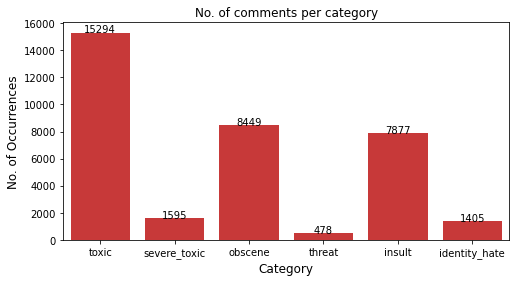

In [9]:
plt.figure(figsize=(8, 4)) #plot a chart with the following size

ax = sns.barplot(x=data_count.index, y=data_count.values, color='#df2121') #plot bar chart

plt.title('No. of comments per category')
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center')

plt.show()

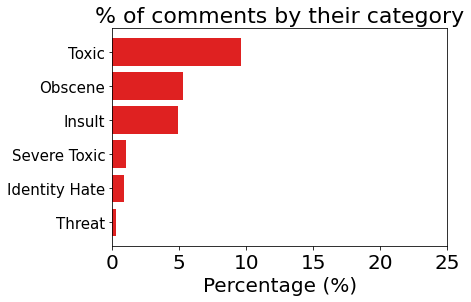

In [10]:
total_com = data['comment_text'].size

#create a bar graph 
sum_tox = data['toxic'].sum() / total_com * 100
sum_sev = data['severe_toxic'].sum() / total_com * 100
sum_obs = data['obscene'].sum() / total_com * 100
sum_thr = data['threat'].sum() / total_com * 100
sum_ins = data['insult'].sum() / total_com * 100
sum_ide = data['identity_hate'].sum() / total_com * 100

#initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

#let the individual variable be the x-axis, whereas the % of toxicity for each category be the y-axis
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr], color='#df2121', alpha=1)
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments by their category', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

#invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()

### Checking Comment Length

average length of comment: 394.073


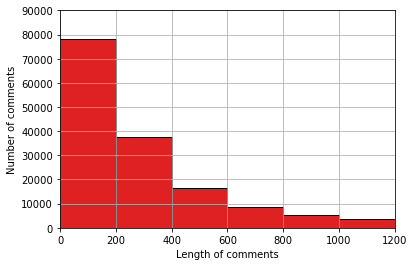

In [11]:
comment = data['comment_text']
#store length of each comment using a list comprehension
x = [len(comment[i]) for i in range(comment.shape[0])]
#print avg. length of a comment
print('average length of comment: {:.3f}'.format(sum(x)/len(x))) 
#initialize 7 bins with the values representing the lenght of the comments
bins = [1,200,400,600,800,1000,1200] 
ax = sns.histplot(x, bins=bins, color='#df2121', alpha=1) #plot chart
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

### Number Of Comments Classified Based On Their Lengths

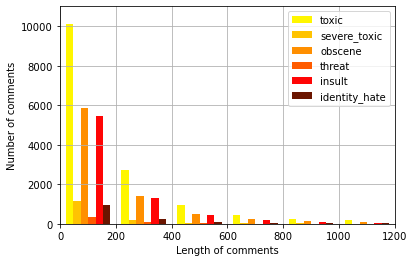

In [12]:
#get the dataset of all 6 categories and store it in a new variable called label
label = data[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]
#get values of label dataset
label = label.values
#create a new array with the same shape as label
y = np.zeros(label.shape)
#create a loop which checks through each category of the label dataset
#and stores comment length as values to the new array 'y'
for i in range(comment.shape[0]):
    l = len(comment[i]) 
    #if label[row]['toxic'] true
    if label[i][0]:
        #store length of comment[i] in y[row][column: 0]
        y[i][0] = l
    #if label[row]['severe_toxic'] true
    if label[i][1]:
        #store length of comment[i] in y[row][column: 1]
        y[i][1] = l
    #if label[row]['obscene'] true
    if label[i][2]:
        #store length of comment[i] in y[row][column: 2]
        y[i][2] = l
    #if label[row]['threat'] true
    if label[i][3]:
        #store length of comment[i] in y[row][column: 3]
        y[i][3] = l
    #if label[row]['insult'] true
    if label[i][4]:
        #store length of comment[i] in y[row][column: 4]
        y[i][4] = l
    #if label[row]['identity_hate'] true
    if label[i][5]:
        #store length of comment[i] in y[row][column: 5]
        y[i][5] = l
#plot chart
labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['#fff600', '#ffc302', '#ff8f00', '#ff5b00', '#ff0505', '#6B1500']        
plt.hist(y, bins=bins, label=labelsplt, color=color)
plt.axis([0, 1200, 0, 11000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

# Pre-processing the Text

In [13]:
#import packages
import re
import string

#remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

#replace punctuation with white space & convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

#remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub('\n', ' ', x)

#remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

#apply all the lambda functions wrote previously through .map on the comments column
comment = comment.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [14]:
comment[4] #cleaned up comment

'you  sir  are my hero  any chance you remember what page that s on '

### Removing Lengthy Comments
There are some comments that are lenghty. These have major consequences, such as increasing the number of words in the training dataset, increasing training time and decreasing accuracy. As a result, a 400-character threshold will be established, and only comments with a length of less than 400 characters will be utilised.

In [15]:
data = data[comment.str.split().str.len().lt(400)]

In [16]:
data.iloc[:, 2:].sum()

toxic            15009
severe_toxic      1493
obscene           8273
threat             467
insult            7727
identity_hate     1375
dtype: int64

# Word Frequency By Category
It is important to know which words occur most frequently in each category.

**Trigger Warning: profanity ahead!**

In [17]:
#create dataset for comments of each category
data_tox = data.loc[:,['id','comment_text','toxic']]
data_sev = data.loc[:,['id','comment_text','severe_toxic']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_thr = data.loc[:,['id','comment_text','threat']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]

In [34]:
import wordcloud
from wordcloud import WordCloud

In [35]:
def word_cloud(ds, label):
    
    #use rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset = ds[ds[label] == 1]
    text = subset.comment_text.values
    wc = WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

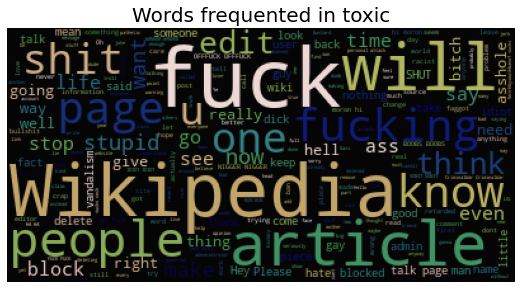

In [36]:
word_cloud(data_tox, 'toxic')

The larger the word, the more frequently it occurs in the dataset.

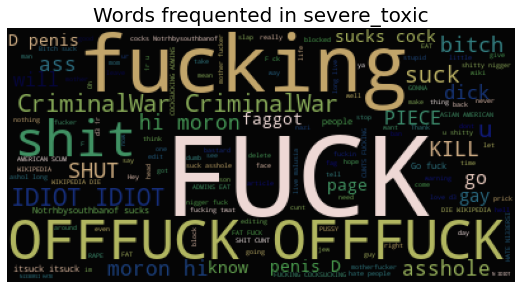

In [37]:
word_cloud(data_sev, 'severe_toxic')

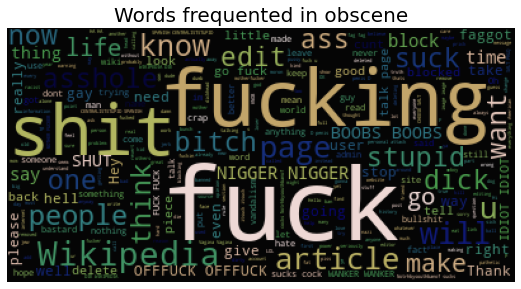

In [38]:
word_cloud(data_obs, 'obscene')

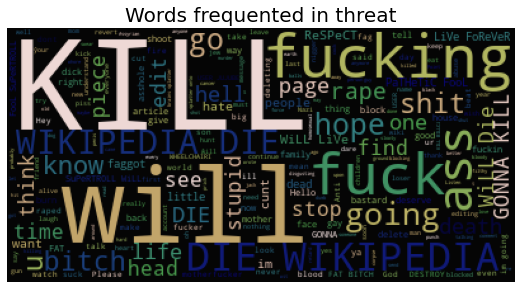

In [39]:
word_cloud(data_thr, 'threat')

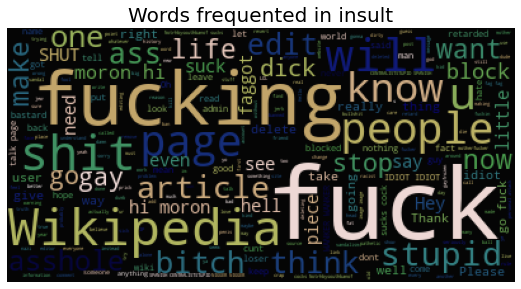

In [40]:
word_cloud(data_ins, 'insult')

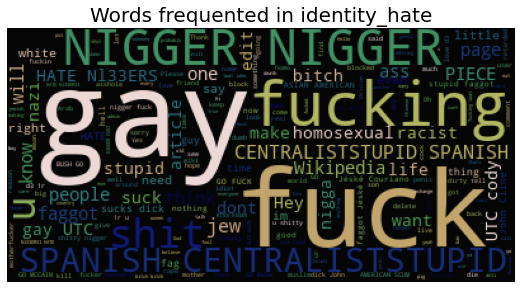

In [41]:
word_cloud(data_ide, 'identity_hate')

# Class Imbalance

The target classes' training samples are not evenly distributed. As previously stated, toxic remarks account for fewer than 10% of the total number of comments in our dataset. 

As a result, the model is more skewed toward the class with the most training occurrences, lowering the model's prediction power. The issue of class imbalance can be addressed by selecting a subset of the data in which toxic remarks account for at least 20% (preferably 50%) relative to non-toxic comments. 

Finally, we will merge the subset of comments that are toxic with the comments that are not toxic, hence, balancing the dataset for training and testing.

In [42]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:] #5000 rows of toxic comments
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:] #5000 rows of comments that are not toxic
#print dataset shape
print('Balanced dataset for \'toxic\' = 1: ', data_tox_1.shape)
print('Balanced dataset for \'toxic\' = 0: ', data_tox_0.shape)
#concatenate the rows of both the datasets
data_tox_concat = pd.concat([data_tox_1, data_tox_0], axis=0)
print('Concatenated balanced dataset: ', data_tox_concat.shape)

Balanced dataset for 'toxic' = 1:  (5000, 3)
Balanced dataset for 'toxic' = 0:  (5000, 3)
Concatenated balanced dataset:  (10000, 3)


In [167]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1493,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1493,:]
data_sev_concat = pd.concat([data_sev_1, data_sev_0], axis=0)
print('Concatenated balanced dataset: ', data_sev_concat.shape)

Concatenated balanced dataset:  (2986, 3)


In [168]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_concat = pd.concat([data_obs_1, data_obs_0], axis=0)
print('Concatenated balanced dataset: ', data_obs_concat.shape)

Concatenated balanced dataset:  (10000, 3)


In [169]:
#we include 1868 comments that have no threat so that the data with threat will represent 20% of the dataset
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:467,:] #20%
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1868,:] #80%
data_thr_concat = pd.concat([data_thr_1, data_thr_0], axis=0)
print('Concatenated balanced dataset: ', data_thr_concat.shape)

Concatenated balanced dataset:  (2335, 3)


In [170]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_concat = pd.concat([data_ins_1, data_ins_0], axis=0)
print('Concatenated balanced dataset: ', data_ins_concat.shape)

Concatenated balanced dataset:  (10000, 3)


In [171]:
#we include 5500 comments that have no identity_hate so that the data with identity_hate will represent 20% of the dataset
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1375,:] #20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5500,:] #80%
data_ide_concat = pd.concat([data_ide_1, data_ide_0], axis=0)
print('Concatenated balanced dataset: ', data_ide_concat.shape)

Concatenated balanced dataset:  (6875, 3)


|Category       | Dataset name    |   Toxic (1)      |   ~Toxic (0)     |   Total data pts |
|:--------------|:----------------|-----------------:|-----------------:|-----------------:|
| Toxic         | data_tox_concat |             5000 |             5000 |            10000 |
| Severe Toxic  | data_sev_concat |             1493 |             1493 |             2986 |
| Obscene       | data_obs_concat |             5000 |             5000 |            10000 |
| Threat        | data_thr_concat |              467 |             1868 |             2335 |
| Insult        | data_ins_concat |             5000 |             5000 |            10000 |
| Identity Hate | data_ide_concat |             1375 |             5500 |             6875 |

# Cross-Validation Of Machine Learning Models

The dataset now needs to be trained and tested so that it will accurately predict the toxcitiy of a comment. However, first, different machine learning algorithms need to be compared with each other in order to get the best results. To measure and contrast the precision of each model, data from each category will run through an F1 score metric. Thus, the most precise model will be selected for the finished product.

In [172]:
#import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

#import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

#import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

Create a simple function which takes in a dataset and allows the user to choose the dataset, toxicity label, vectorizer and number of ngrams. 

In [173]:
'''
df_concat: data_tox_concat, data_sev_concat, ...
label: toxic, severe_toxic, ...
vectorizer values: CountVectorizer, TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
def cv_tf_train_test(df_concat, label, vectorizer, ngram):

    ''' Train/Test split'''
    #split the data into X and y data sets
    X = df_concat.comment_text
    y = df_concat[label]

    #split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    #create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')

    X_train_cv1 = cv1.fit_transform(X_train) #learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      #transform documents to document-term matrix.


    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('Logistic Regression: done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)
    print('K Nearest Neighbors: done')

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('BernoulliNB: done')

    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('MultinomialNB: done')

    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)
    print('Linear SVC: done')

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('RandomForest  Classifier: done')

    #create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 

    #create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1

### Create TFIDFvectorizer object and calculate the F1 scores across all models.

In [174]:
#F1 score of models for category: 'toxic'
df_tox_cv = cv_tf_train_test(data_tox_concat, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)
df_tox_cv

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(toxic)
Log Regression,0.871569
KNN,0.182246
BernoulliNB,0.793642
MultinomialNB,0.872241
SVM,0.873409
Random Forest,0.842887


In [175]:
#F1 score of models for category: 'severe_toxic'
df_sev_cv = cv_tf_train_test(data_sev_concat, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
df_sev_cv 

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(severe_toxic)
Log Regression,0.916859
KNN,0.892667
BernoulliNB,0.828096
MultinomialNB,0.939037
SVM,0.928974
Random Forest,0.936027


In [176]:
#F1 score of models for category: 'obscene'
df_obs_cv = cv_tf_train_test(data_obs_concat, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
df_obs_cv

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(obscene)
Log Regression,0.900653
KNN,0.483933
BernoulliNB,0.790185
MultinomialNB,0.886571
SVM,0.913190
Random Forest,0.908783


In [177]:
#F1 score of models for category: 'obscene'
df_thr_cv = cv_tf_train_test(data_thr_concat, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
df_thr_cv

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(threat)
Log Regression,0.677824
KNN,0.781022
BernoulliNB,0.247191
MultinomialNB,0.512077
SVM,0.836879
Random Forest,0.850000


In [178]:
#F1 score of models for category: 'insult'
df_ins_cv = cv_tf_train_test(data_ins_concat, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
df_ins_cv

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(insult)
Log Regression,0.894342
KNN,0.209181
BernoulliNB,0.811643
MultinomialNB,0.897001
SVM,0.906063
Random Forest,0.884974


In [179]:
#F1 score of models for category: 'identity_hate'
df_ide_cv = cv_tf_train_test(data_ide_concat, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
df_ide_cv

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(identity_hate)
Log Regression,0.699577
KNN,0.155136
BernoulliNB,0.535304
MultinomialNB,0.510000
SVM,0.808878
Random Forest,0.790464


In [180]:
#combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
#transpose the dataframe to make it suitable for presentation on a graph
f1_all_trp = f1_all.transpose() 
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.871569,0.182246,0.793642,0.872241,0.873409,0.842887
F1 Score(severe_toxic),0.916859,0.892667,0.828096,0.939037,0.928974,0.936027
F1 Score(obscene),0.900653,0.483933,0.790185,0.886571,0.913190,0.908783
F1 Score(insult),0.894342,0.209181,0.811643,0.897001,0.906063,0.884974
F1 Score(threat),0.677824,0.781022,0.247191,0.512077,0.836879,0.850000
F1 Score(identity_hate),0.699577,0.155136,0.535304,0.510000,0.808878,0.790464


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

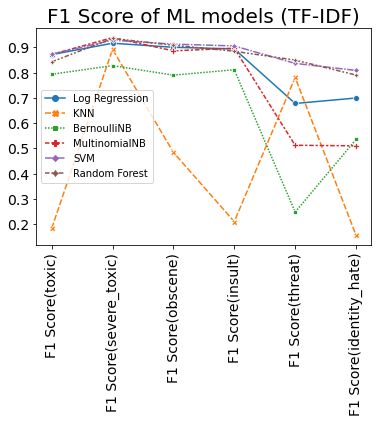

In [181]:
#plot the data on chart
sns.lineplot(data = f1_all_trp, markers = True)
plt.xticks(rotation = '90', fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = 'best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

### Now, create CountVectorizer object and calculate the F1 scores across all models.

In [182]:
df_tox_v = cv_tf_train_test(data_tox_concat, 'toxic', CountVectorizer, (1,1))
df_tox_v.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)
df_tox_v

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(toxic)
Log Regression,0.879437
KNN,0.648398
BernoulliNB,0.793642
MultinomialNB,0.876368
SVM,0.865262
Random Forest,0.848614


In [183]:
df_sev_v = cv_tf_train_test(data_sev_concat, 'severe_toxic', CountVectorizer, (1,1))
df_sev_v.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
df_sev_v

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(severe_toxic)
Log Regression,0.923429
KNN,0.863780
BernoulliNB,0.828096
MultinomialNB,0.941050
SVM,0.917808
Random Forest,0.930917


In [184]:
df_obs_v = cv_tf_train_test(data_obs_concat, 'obscene', CountVectorizer, (1,1))
df_obs_v.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
df_obs_v

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(obscene)
Log Regression,0.923902
KNN,0.798297
BernoulliNB,0.790185
MultinomialNB,0.895220
SVM,0.920424
Random Forest,0.911367


In [185]:
df_thr_v = cv_tf_train_test(data_thr_concat, 'threat', CountVectorizer, (1,1))
df_thr_v.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
df_thr_v

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(threat)
Log Regression,0.801498
KNN,0.658436
BernoulliNB,0.247191
MultinomialNB,0.820513
SVM,0.847222
Random Forest,0.841727


In [186]:
df_ins_v = cv_tf_train_test(data_ins_concat, 'insult', CountVectorizer, (1,1))
df_ins_v.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
df_ins_v

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(insult)
Log Regression,0.898014
KNN,0.740352
BernoulliNB,0.811643
MultinomialNB,0.895939
SVM,0.895792
Random Forest,0.883126


In [187]:
df_ide_v = cv_tf_train_test(data_ide_concat, 'identity_hate', CountVectorizer, (1,1))
df_ide_v.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
df_ide_v

Logistic Regression: done
K Nearest Neighbors: done
BernoulliNB: done
MultinomialNB: done
Linear SVC: done
RandomForest  Classifier: done


,F1 Score(identity_hate)
Log Regression,0.783715
KNN,0.568750
BernoulliNB,0.535304
MultinomialNB,0.807095
SVM,0.795122
Random Forest,0.800000


In [188]:
#combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all_v = pd.concat([df_tox_v, df_sev_v, df_obs_v, df_ins_v, df_thr_v, df_ide_v], axis=1)
#transpose the dataframe to make it suitable for presentation on a graph
f1_all_v_trp = f1_all_v.transpose() 
f1_all_v_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.879437,0.648398,0.793642,0.876368,0.865262,0.848614
F1 Score(severe_toxic),0.923429,0.863780,0.828096,0.941050,0.917808,0.930917
F1 Score(obscene),0.923902,0.798297,0.790185,0.895220,0.920424,0.911367
F1 Score(insult),0.898014,0.740352,0.811643,0.895939,0.895792,0.883126
F1 Score(threat),0.801498,0.658436,0.247191,0.820513,0.847222,0.841727
F1 Score(identity_hate),0.783715,0.568750,0.535304,0.807095,0.795122,0.800000


Text(0.5, 1.0, 'F1 Score of ML models (CountVectorizer)')

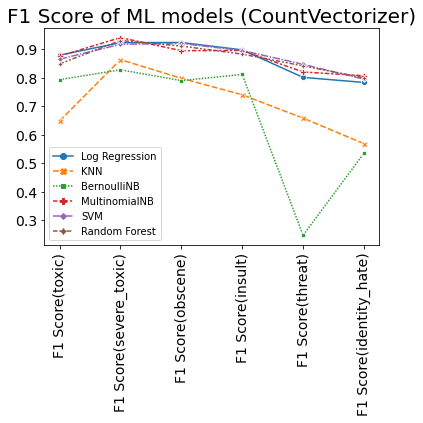

In [189]:
#plot the data on chart
sns.lineplot(data = f1_all_v_trp, markers = True)
plt.xticks(rotation = '90', fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = 'best')
plt.title('F1 Score of ML models (CountVectorizer)', fontsize=20)

The best models are LinearSVC and Random Forest. However, Random Forest will be used instead of LinearSVC, despite the latter's superior performance, because RDF offers a predict_proba function that LinearSVC lacks. The predict_proba function is required to generate a probability score for each comment. Also, instead of CountVectorizer, TF-IDFVectorizer will be used with the Random Forest model because it produces slightly greater accuracy.

# Sample Prediction

In [190]:
X = data_tox_concat.comment_text
y = data_tox_concat['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  #convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  #converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

#train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [191]:
comment1 = ['Go kill yourself! you idiot!']
comment2 = ['I am glad to see you']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

array([1.])

In [192]:
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

array([0.25400996])

Random Forest has assigned a probability of 1 to the first comment. Whereas, the second comment has been assigned a probability of 0.25. This means that the first comment is toxic and the second comment has low toxicity.

# Pickling The Model & The Vectors For Each Category

“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream to store it in a file/database, maintain program state across sessions or transport data over the network. Thus, it allows for a faster execution time. The pickled model and vectors will then be used in the Flask app. Flask is a web framework, a Python module that lets you develop web applications easily.

In [193]:
import pickle

def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    #initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    #convert the X data into a document term matrix dataframe
    X_vect = tfv.fit_transform(X)  
    
    #saves the column labels (ie. the vocabulary)
    #wb means Writing to the file in Binary mode, written in byte objects
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)

    #create a new pickle file based on random forest
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(randomforest, f)

In [194]:
#create a loop to create pickle files all at once.
datalist = [data_tox_concat, data_sev_concat, data_obs_concat, data_ins_concat, data_thr_concat, data_ide_concat]
label = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

for i,j in zip(datalist,label):
    pickle_model(i, j)